In [104]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from chesswinnerprediction.visualization.visualization import plot_pie

In [106]:
original_df = pd.read_csv("../data/raw/lichess_db_standard_rated_2017-03.csv")

In [107]:
baseline_columns = [
    "Event",
    "WhiteElo",
    "BlackElo",
    "TimeControl",
    "Result",
]
TARGET_COLUMNS = ["ResultEncoded", "WhiteWin", "BlackWin", "Draw"]

WHITE_WIN = "1-0"
BLACK_WIN = "0-1"
DRAW = "1/2-1/2"

RESULTS = {
    WHITE_WIN: 1,
    BLACK_WIN: 0,
    DRAW: -1
}

In [143]:
df = original_df[baseline_columns]
df = df[df["Result"] != "*"]

df["Event"] = df["Event"].str.split(" http").str[0]

df["WhiteElo"] = df["WhiteElo"].astype(np.int16)
df["BlackElo"] = df["BlackElo"].astype(np.int16)
df["MeanElo"] = ((df["WhiteElo"] + df["BlackElo"]) / 2).astype(np.float32)
df["EloDiff"] = (df["WhiteElo"] - df["BlackElo"]).astype(np.int16)
df["EloDiffAbs"] = df["EloDiff"].abs().astype(np.int16)

df[["BaseTime", "IncrementTime"]] = df["TimeControl"].str.split("+", expand=True)
df["BaseTime"] = df["BaseTime"].astype(np.int16)
df["IncrementTime"] = df["IncrementTime"].astype(np.int16)
df["ZeroIncrementTime"] = (df["IncrementTime"] == 0).astype(np.int8)

df["ResultEncoded"] = df["Result"].map(RESULTS)
df["WhiteWin"] = (df["Result"] == "1-0").astype(np.int8)
df["BlackWin"] = (df["Result"] == "0-1").astype(np.int8)
df["Draw"] = (df["Result"] == "1/2-1/2").astype(np.int8)

df.drop(columns=["TimeControl"], inplace=True)

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122226 entries, 0 to 122230
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Event          122226 non-null  object 
 1   WhiteElo       122226 non-null  int16  
 2   BlackElo       122226 non-null  int16  
 3   Result         122226 non-null  object 
 4   MeanElo        122226 non-null  float32
 5   EloDiff        122226 non-null  int16  
 6   EloDiffAbs     122226 non-null  int16  
 7   BaseTime       122226 non-null  int16  
 8   IncrementTime  122226 non-null  int16  
 9   ResultEncoded  122226 non-null  int64  
 10  WhiteWin       122226 non-null  int8   
 11  BlackWin       122226 non-null  int8   
 12  Draw           122226 non-null  int8   
dtypes: float32(1), int16(6), int64(1), int8(3), object(2)
memory usage: 5.9+ MB


In [110]:
df.head()

,Event,WhiteElo,BlackElo,Result,MeanElo,EloDiff,EloDiffAbs,BaseTime,IncrementTime,ResultEncoded,WhiteWin,BlackWin,Draw
0,Rated Blitz game,1234,1467,0-1,1350.5,-233,233,300,0,0,0,1,0
1,Rated Blitz game,1988,1960,1-0,1974.0,28,28,180,0,1,1,0,0
2,Rated Blitz game,1891,1900,1-0,1895.5,-9,9,300,0,1,1,0,0
3,Rated Classical game,1342,1364,1-0,1353.0,-22,22,600,0,1,1,0,0
4,Rated Classical game,1575,1630,0-1,1602.5,-55,55,900,15,0,0,1,0


## Idea
Result depends on the Elo of the players. Let's see correlation between Elo and Result.

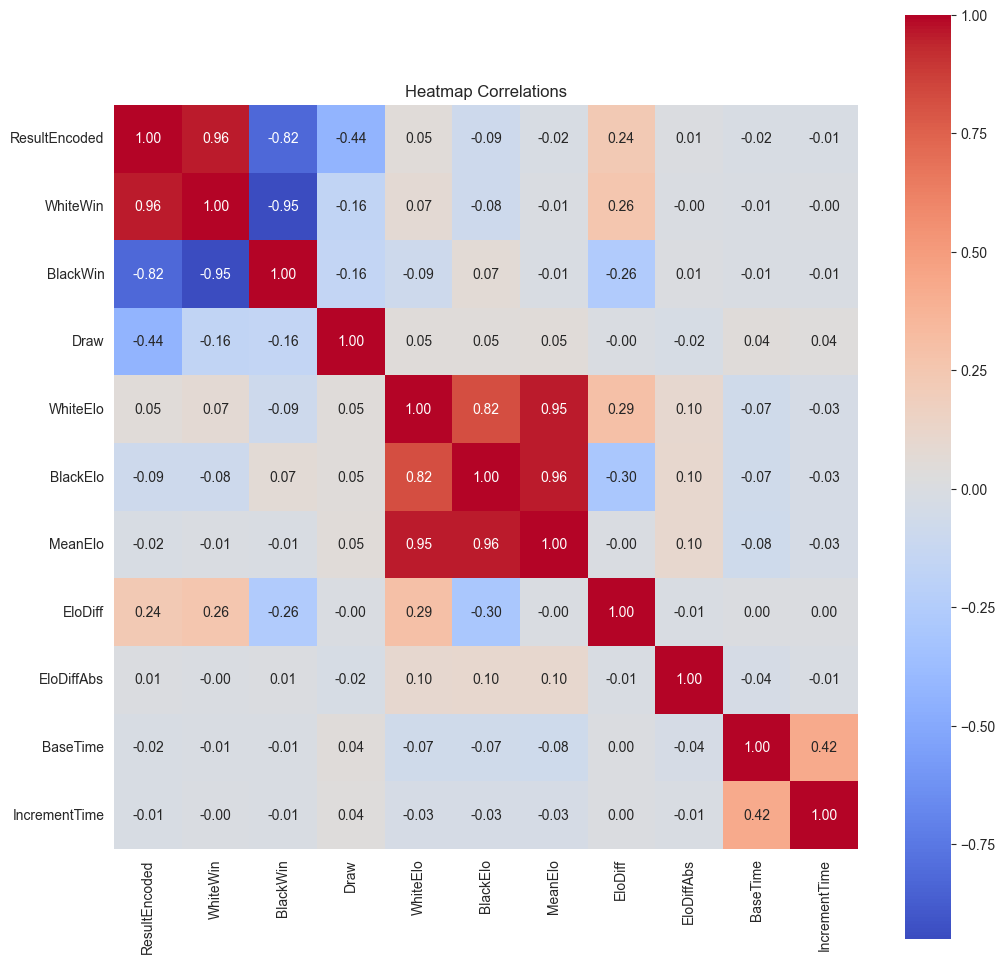

In [111]:
def plot_heatmap(data):
    reordered_columns = TARGET_COLUMNS + [
        col for col in data.columns if col not in TARGET_COLUMNS
    ]
    data = data[reordered_columns]

    numeric_df = data.select_dtypes(include="number")
    plt.figure(figsize=(12, 12))
    sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title("Heatmap Correlations")
    plt.show()


plot_heatmap(df)

White elo has positive correlation with white win and negative correlation with black win. Same for black elo.

Also, Elo has small correlation with draw.

Let's see the distribution of the results, where:
   - "1-0": White wins
   - "0-1": Black wins
   - "1/2-1/2": Draw

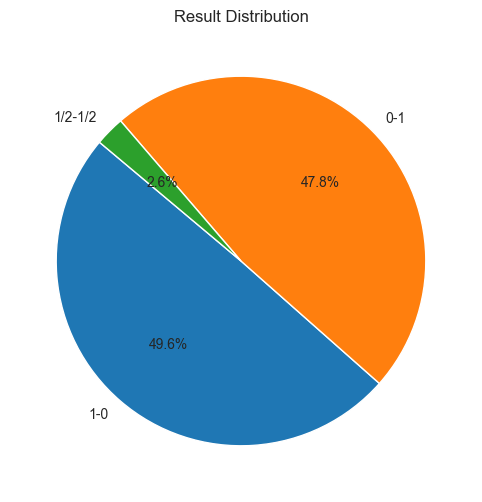

In [112]:
_, axs = plt.subplots(figsize=(12, 6))
plot_pie(axs, df, "Result", "Result Distribution", threshold=0)
plt.show()

And let's see the distribution of Events.

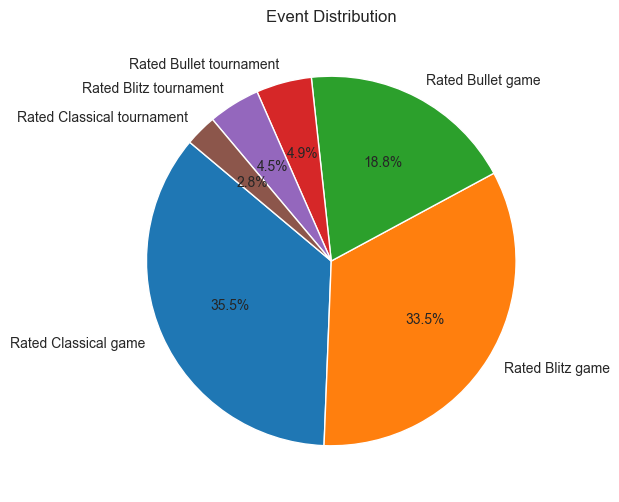

In [113]:
_, axs = plt.subplots(figsize=(12, 6))
plot_pie(axs, df, "Event", "Event Distribution", threshold=0)
plt.show()

And now - the distribution of the results for each event.

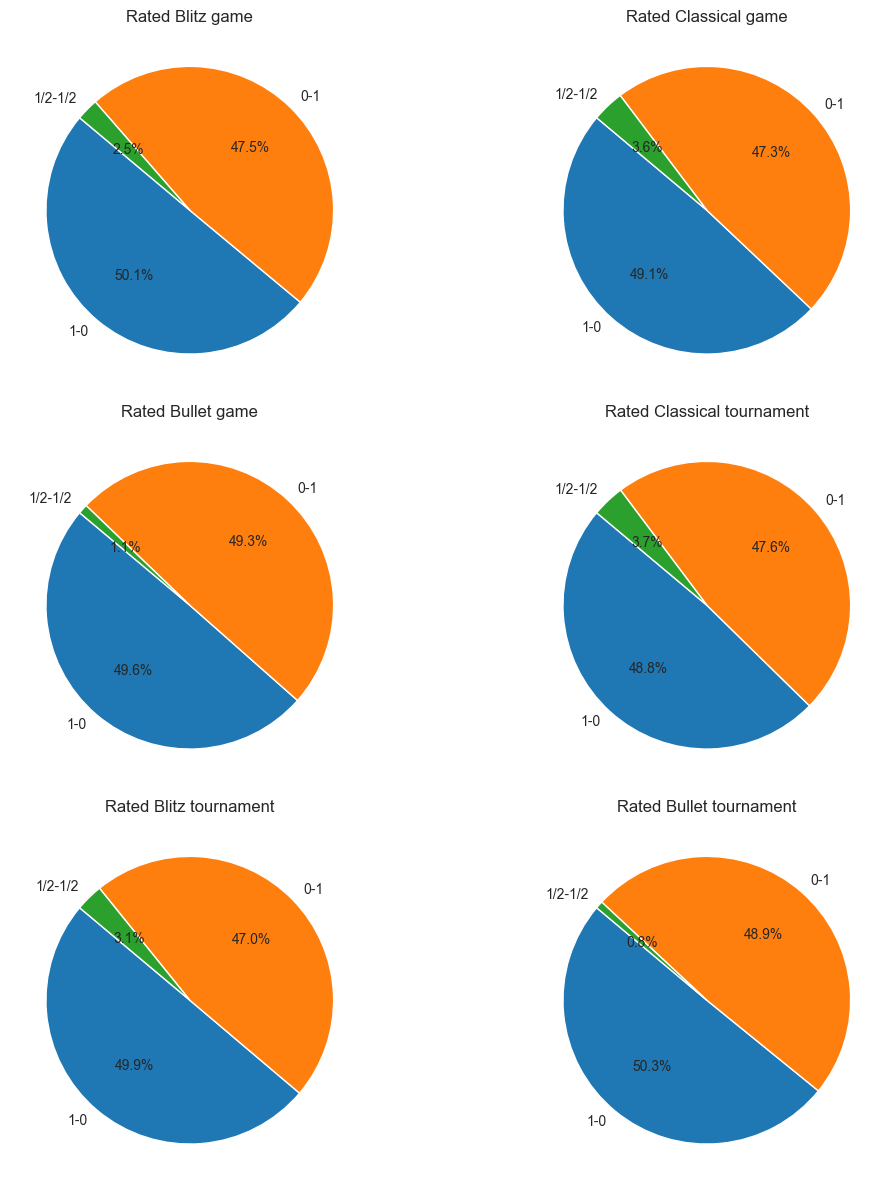

In [114]:
_, axs = plt.subplots(3, 2, figsize=(12, 12))
idx = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]

events = df["Event"].unique()
for (i, j), event in zip(idx, events):
    event_df = df[df["Event"] == event]
    plot_pie(axs[i][j], event_df, column_name="Result", title=f"{event}", threshold=0)

plt.tight_layout()
plt.show()

## Elo vs Result

Let's compare mean Elo of all games and mean Elo of draws.

Mean Elo: 1623.4574
Mean Elo for Draw: 1707.0508


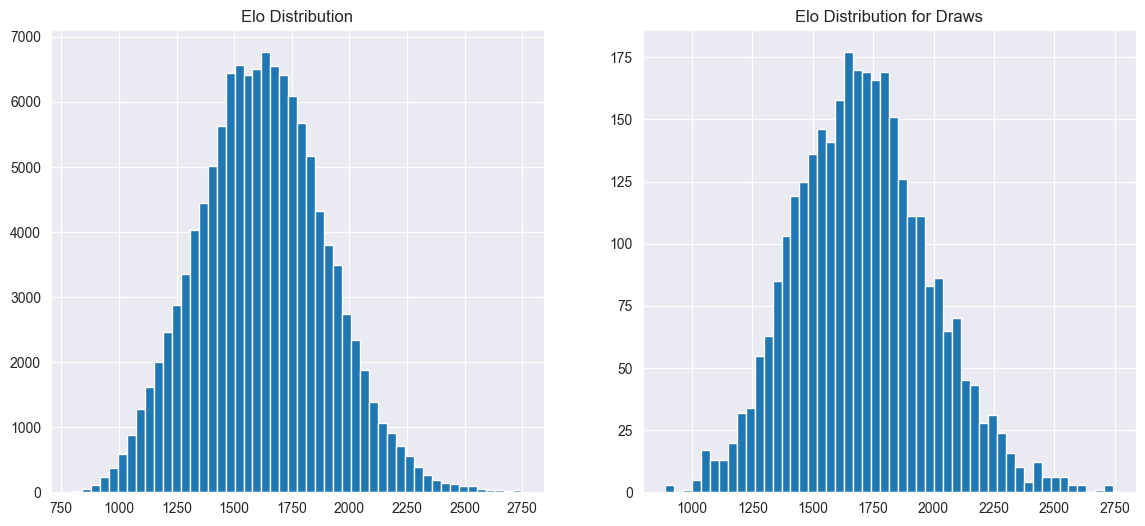

In [115]:
print("Mean Elo:", df["MeanElo"].mean())
print("Mean Elo for Draw:", df[df["Draw"] == 1]["MeanElo"].mean())

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

df["MeanElo"].hist(bins=50, ax=axes[0])
axes[0].set_title("Elo Distribution")

df[df["Draw"] == 1]["MeanElo"].hist(bins=50, ax=axes[1])
axes[1].set_title("Elo Distribution for Draws")

plt.show()

Draws have higher mean Elo.

And let's compare mean winner elo with mean loser elo

white Wins
White mean elo: 1643.8562306118408
Black mean elo: 1600.134974589136


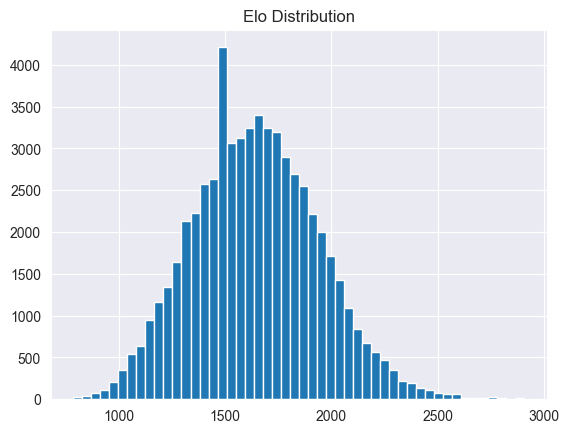

In [116]:
white_wins_df = df[df["WhiteWin"] == 1]
print("white Wins")
print("White mean elo:", white_wins_df["WhiteElo"].mean())
print("Black mean elo:", white_wins_df["BlackElo"].mean())

white_wins_df["WhiteElo"].hist(bins=50)
plt.title("Elo Distribution")
plt.show()

Black Wins
Black mean elo: 1644.3871326422388
White mean elo: 1596.5095111019878


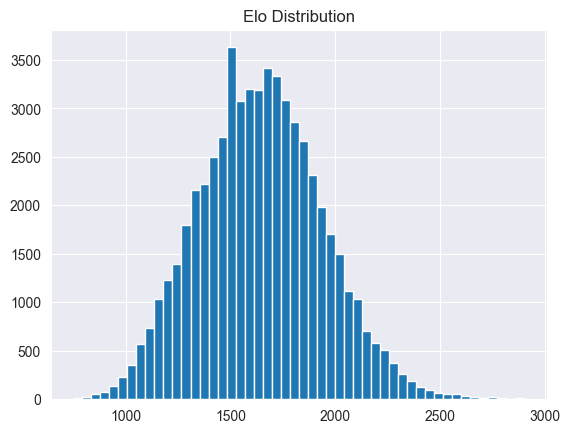

In [117]:
black_wins_df = df[df["BlackWin"] == 1]
print("Black Wins")
print("Black mean elo:", black_wins_df["BlackElo"].mean())
print("White mean elo:", black_wins_df["WhiteElo"].mean())

black_wins_df["BlackElo"].hist(bins=50)
plt.title("Elo Distribution")
plt.show()

In [118]:
del white_wins_df
del black_wins_df

## Time Control Exploration

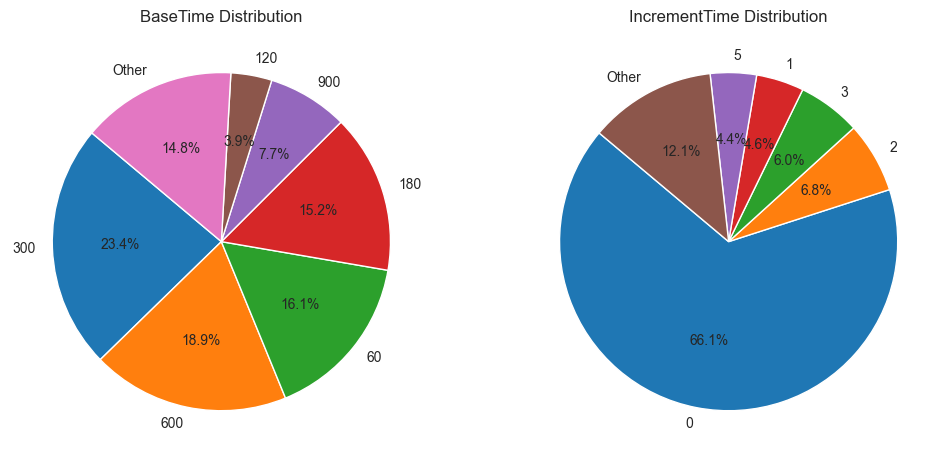

In [119]:
_, axs = plt.subplots(1, 2, figsize=(12, 6))
plot_pie(axs[0], df, "BaseTime", "BaseTime Distribution", threshold=0.03)
plot_pie(axs[1], df, "IncrementTime", "IncrementTime Distribution", threshold=0.04)
plt.show()

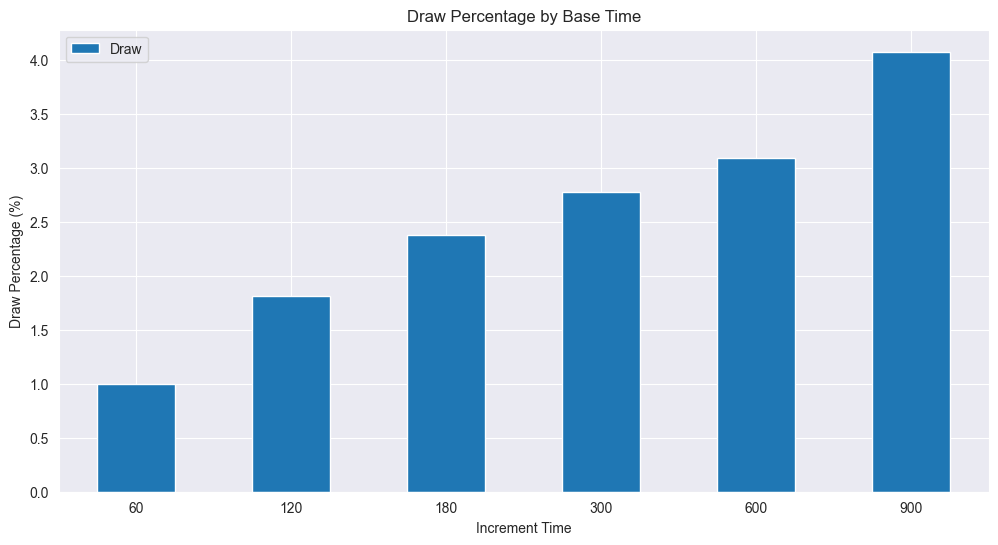

In [181]:
popular_base_times = [60, 120, 180, 300, 600, 900]

popular_base_times_df = df[df["BaseTime"].isin(popular_base_times)][["BaseTime", "Draw"]]
pct_draw_values = popular_base_times_df.groupby("BaseTime").mean() * 100

_, ax = plt.subplots(figsize=(12, 6))
pct_draw_values.plot(kind="bar", ax=ax)
ax.set_title("Draw Percentage by Base Time")
ax.set_ylabel("Draw Percentage (%)")
ax.set_xlabel("Increment Time")
plt.xticks(rotation=0)
plt.show()

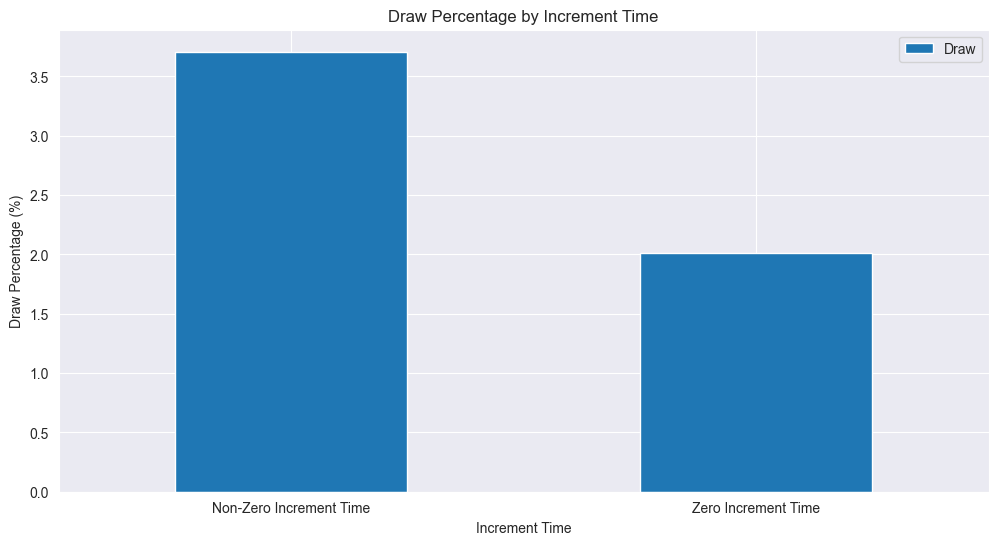

In [180]:
increment_time_df = df[["ZeroIncrementTime", "Draw"]].copy()
increment_time_df["ZeroIncrementTime"] = increment_time_df["ZeroIncrementTime"].map(
    {0: "Non-Zero Increment Time", 1: "Zero Increment Time"}
)
pct_draw_values = increment_time_df.groupby("ZeroIncrementTime").mean() * 100

ax = pct_draw_values.plot(kind="bar", figsize=(12, 6))
ax.set_title("Draw Percentage by Increment Time")
ax.set_ylabel("Draw Percentage (%)")
ax.set_xlabel("Increment Time")
plt.xticks(rotation=0)
plt.show()

In [121]:
df["DrawEventProb"] = df.groupby("Event")["Draw"].transform("mean")
df["WhiteWinEventProb"] = df.groupby("Event")["WhiteWin"].transform("mean")
df["BlackWinEventProb"] = df.groupby("Event")["BlackWin"].transform("mean")


In [122]:
df["EventMeanElo"] = df.groupby("Event")["MeanElo"].transform("mean")
df["EventMeanEloDiff"] = df.groupby("Event")["EloDiff"].transform("mean")
df["EventMeanEloDiffAbs"] = df.groupby("Event")["EloDiffAbs"].transform("mean")

In [123]:
df["MeanEloDivWhiteWinProb"] = df["MeanElo"] / df["WhiteWinEventProb"]
df["MeanEloDivBlackWinProb"] = df["MeanElo"] / df["BlackWinEventProb"]
df["MeanEloDivDrawProb"] = df["MeanElo"] / df["RawEventProb"]

In [124]:
df["EloDiffDivWhiteWinProb"] = df["EloDiff"] / df["WhiteWinEventProb"]
df["EloDiffDivBlackWinProb"] = df["EloDiff"] / df["BlackWinEventProb"]
df["EloDiffDivDrawProb"] = df["EloDiff"] / df["RawEventProb"]

In [125]:
df["EloDiffAbsDivWhiteWinProb"] = df["EloDiffAbs"] / df["WhiteWinEventProb"]
df["EloDiffAbsDivBlackWinProb"] = df["EloDiffAbs"] / df["BlackWinEventProb"]
df["EloDiffAbsDivDrawProb"] = df["EloDiffAbs"] / df["RawEventProb"]

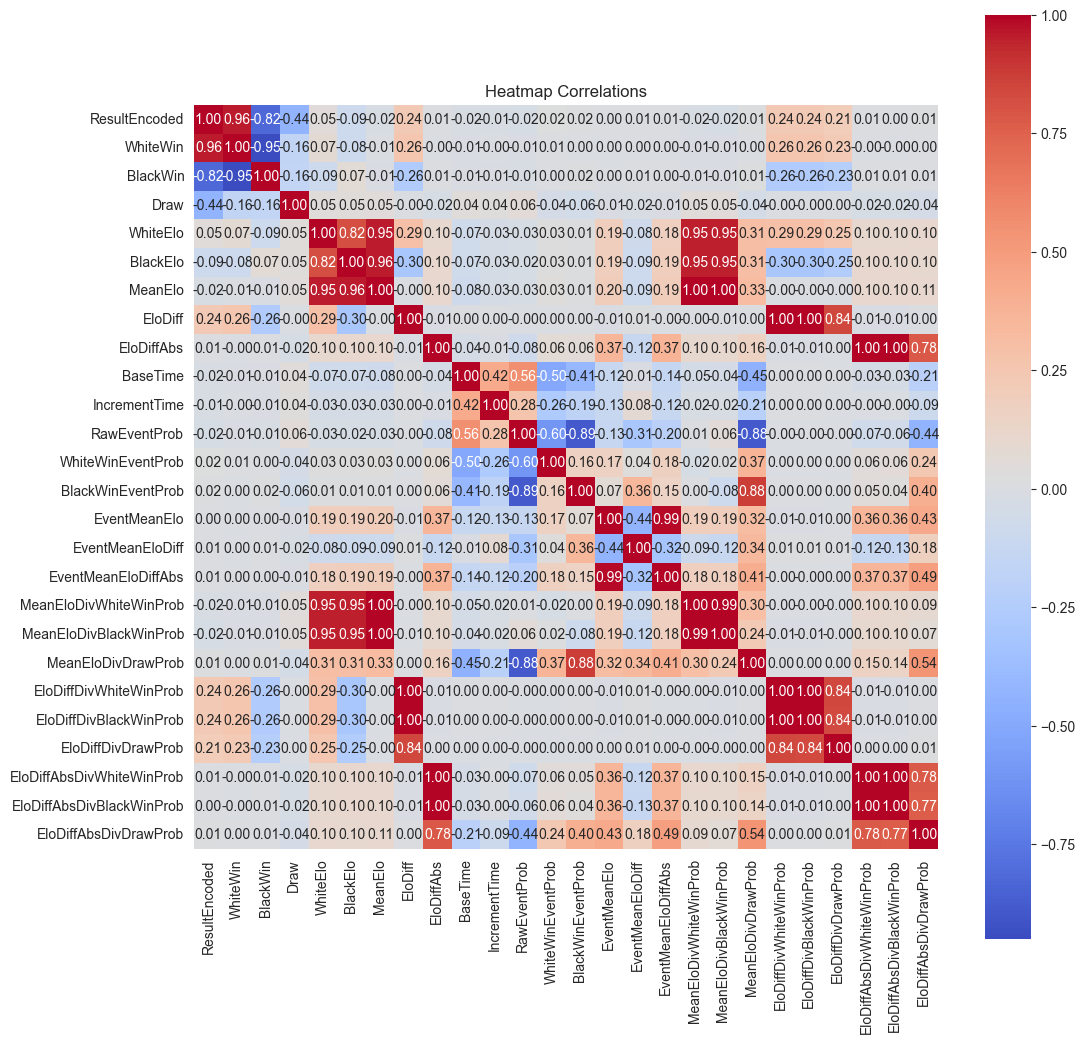

In [126]:
plot_heatmap(df)

In [127]:
df = pd.get_dummies(df, columns=["Event"], dtype=np.int8)

In [128]:
df.drop(columns=["Result"], inplace=True)

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122226 entries, 0 to 122230
Data columns (total 32 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   WhiteElo                          122226 non-null  int16  
 1   BlackElo                          122226 non-null  int16  
 2   MeanElo                           122226 non-null  float32
 3   EloDiff                           122226 non-null  int16  
 4   EloDiffAbs                        122226 non-null  int16  
 5   BaseTime                          122226 non-null  int16  
 6   IncrementTime                     122226 non-null  int16  
 7   ResultEncoded                     122226 non-null  int64  
 8   WhiteWin                          122226 non-null  int8   
 9   BlackWin                          122226 non-null  int8   
 10  Draw                              122226 non-null  int8   
 11  RawEventProb                      122226 non-null  float6

In [130]:
df.head()

,WhiteElo,BlackElo,MeanElo,EloDiff,EloDiffAbs,BaseTime,IncrementTime,ResultEncoded,WhiteWin,BlackWin,...,EloDiffDivDrawProb,EloDiffAbsDivWhiteWinProb,EloDiffAbsDivBlackWinProb,EloDiffAbsDivDrawProb,Event_Rated Blitz game,Event_Rated Blitz tournament,Event_Rated Bullet game,Event_Rated Bullet tournament,Event_Rated Classical game,Event_Rated Classical tournament
0,1234,1467,1350.5,-233,233,300,0,0,0,1,...,-9427.290514,465.431652,490.863243,9427.290514,1,0,0,0,0,0
1,1988,1960,1974.0,28,28,180,0,1,1,0,...,1132.893281,55.931701,58.987858,1132.893281,1,0,0,0,0,0
2,1891,1900,1895.5,-9,9,300,0,1,1,0,...,-364.144269,17.978047,18.960383,364.144269,1,0,0,0,0,0
3,1342,1364,1353.0,-22,22,600,0,1,1,0,...,-611.712821,44.845716,46.465988,611.712821,0,0,0,0,1,0
4,1575,1630,1602.5,-55,55,900,15,0,0,1,...,-1529.282051,112.114291,116.164971,1529.282051,0,0,0,0,1,0


In [131]:
def estimate_prediction_by_elo(data_df: pd.DataFrame):
    white_elo_more_than_black = data_df["WhiteElo"] > data_df["BlackElo"]

    white_win_condition = white_elo_more_than_black & (data_df["WhiteWin"] == 1)
    black_win_condition = ~white_elo_more_than_black & (data_df["BlackWin"] == 1)

    return (
        len(data_df[white_win_condition]) + len(data_df[black_win_condition])
    ) / len(data_df)

In [132]:
estimate_prediction_by_elo(df)

0.5865855055389197